# Histopathologic Cancer Detection Using a CNN

#### By Matthew Prout

## Overview

The purpose of this notebook is to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.  The data comes from Bas Veeling and was posted to the [Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection) website.

This notebook gave me a chance to practice some of the concepts I learned in the [Deep Learning Specialization course](https://www.coursera.org/specializations/deep-learning), especially the second course called 
"Improving Deep Neural Networks: Hyperparameter tuning, Regularization and Optimization."  In addition, it also gave me a chance to try training a model on a Deep Learning AMI on AWS and learn how to setup this environment.

In [8]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import math

import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence

In [9]:
# Load TensorBoard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [10]:
# Path to the training data
project_path = '/home/ubuntu/notebooks/HistopathologicCancerDetection/'
train_path = os.path.join(project_path, 'train')

## Exploratory Data Analysis

In [11]:
data = pd.read_csv(os.path.join(project_path, 'train_labels.csv'), header=0)
print('The number of examples is: {}'.format(len(data)))

The number of examples is: 220025


Look at an image to get its dimensions:

In [12]:
image = Image.open(os.path.join(train_path, '0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif'))
image_array = np.array(image)
height, width, channels = image_array.shape
print('Height: {}, Width: {}, Channels: {}'.format(height, width, channels))

Height: 96, Width: 96, Channels: 3


### Look at Examples of Images with Cancer and Images with No Cancer

In [155]:
%matplotlib inline

def showExampleImages(df, number, cancer):
    title = 'No Cancer'
    compare_id = 0

    if cancer:
        title = 'Cancer'
        compare_id = 1

    fig, axes = plt.subplots(1, number, figsize=(20,20))

    for i in range(number):
        axes[i].imshow(Image.open(os.path.join(train_path, df[df.label == compare_id].iloc[i].id + '.tif')))
        axes[i].set_title(title)

#### Examples of Cancer Images

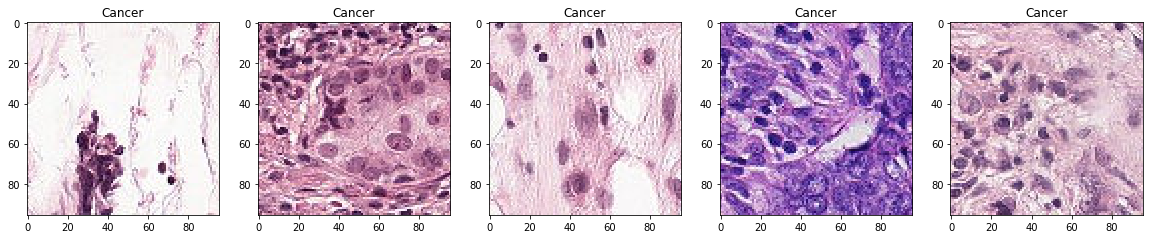

In [156]:
showExampleImages(data, 5, cancer=True)

#### Examples of No Cancer Images

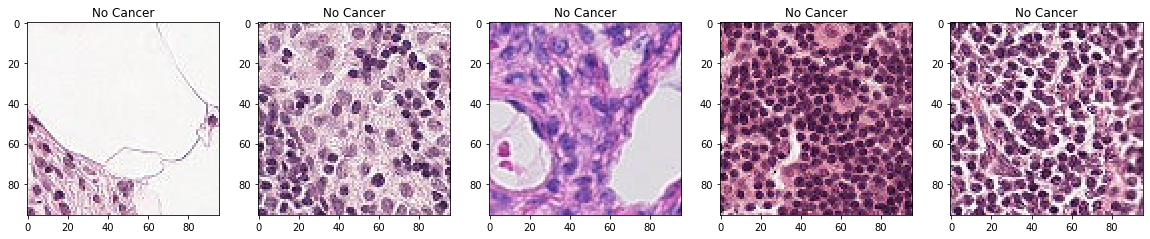

In [157]:
showExampleImages(data, 5, cancer=False)

Based on a manual inspection with an untrained eye, it is difficult to distinguish between the cancer and no-cancer images.

## Training

Due to the large number of examples in the dataset (220,025), I choose to parition the data into a 80% train, 10% validation, and 10% test split:

In [34]:
# Note: Split the training data 80/10/10 between train/dev/test

train_start = 0
train_len = int(0.8 * len(data))
train_end = train_start + train_len - 1

dev_start = train_end + 1
dev_len = int(0.1 * len(data))
dev_end = dev_start + dev_len - 1

test_start = dev_end + 1
test_len = len(data) - test_start
test_end = test_start + test_len - 1

In [39]:
print('The number of training examples is still large: {}'.format(train_len))

The number of training examples is still large: 176020


Rather than loading all the images into memory, I chose to create a data generator to dynamically load the data into the model.  This DataGenerator was inspired by [Shervine Amidi](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly) at Stanford, but it has been modified to allow a smaller training set within the available data in order to speed up training.

In [40]:
class DataGenerator(Sequence):
    
    def __init__(self, data, batch_size, dim, start, space, total_batch_length=None, shuffle=False):
        '''
        data: dataframe containing indicies to the images
        batch_size: number of images in each batch (e.g. 32, 64)
        dim: the image dimensions (including the number of channels)
        start: the start location of train/dev/test in the list of images
        space: the total length (number) of images available for this set
        total_batch_length: the total length of data to be used for this set (batch_size*number of batches). Must
        be less than or equal to 'space'.
        shuffle: whether to shuffle the data after each epoch
        '''
        
        # Set the length less than the available range to have
        # fewer batches in an epoch
        
        if total_batch_length is not None:
            assert(total_batch_length <= space)
            self.length = total_batch_length
        else:
            self.length = space
            
        self.data = data
        self.batch_size = batch_size
        self.dim = dim
        self.start = start
        self.space = space
        self.indicies = None
        self.shuffle = shuffle
        self.on_epoch_end()
        
    
    # Supposed to be called at the end of every epoch, but a bug in Keras is blocking this.
    # See workaround in __len__ below.
    def on_epoch_end(self):
        
        if self.shuffle:
            self.indicies = np.random.randint(0, self.space, self.length)
        else:
            self.indicies = np.arange(self.length)
        
        
    def __len__(self):
        
        # Work-around for https://github.com/tensorflow/tensorflow/issues/35911
        self.on_epoch_end()
        
        return math.floor(self.length/self.batch_size)
        

    def __getitem__(self, index):
               
        batch_pos = self.batch_size*index
    
        X_batch = np.zeros((self.batch_size, *self.dim))
        Y_batch = np.zeros((self.batch_size))

        for idx in range(self.batch_size):
            
            shuffled_index = self.indicies[batch_pos + idx]

            X_batch[idx] = np.array(Image.open(os.path.join(train_path, self.data.loc[shuffled_index+self.start, 'id'] + '.tif')))
            Y_batch[idx] = self.data.loc[shuffled_index+self.start, 'label']

        return X_batch/255, Y_batch

### Training Methodology

For the different network models, I tried different combinations of hyperparameters.  Professor Andrew Ng said that the most important parameters to tune are roughly in this order:

1. alpha (learning rate)
2. beta (momentum), mini-batch size, number of hidden units
3. number of layers, learning rate decay

I mostly adjusted the learning rate, batch size, and beta, and found the best models using TensorBoard.

For this use case (cancer detection), the goal is to find a model with a high accuracy and a low number of false negatives.  This is because it is better to have a false positive than a false negative when it comes to cancer screening.

### Hyper Parameters

In [46]:
learning_rate = 0.001
beta = 0.9
mini_batch_size = 64
num_epochs = 150
num_batches_per_epoch = 100
num_batches_for_dev = 10

In [47]:
print('learning_rate: {}'.format(learning_rate))
print('beta: {}'.format(beta))
print('mini_batch_size: {}'.format(mini_batch_size))
print('num_epochs: {}'.format(num_epochs))
print('num_batches_per_epoch: {}'.format(num_batches_per_epoch))
print('num_batches_for_dev: {}'.format(num_batches_for_dev))

learning_rate: 0.001
beta: 0.9
mini_batch_size: 64
num_epochs: 150
num_batches_per_epoch: 100
num_batches_for_dev: 10


Create the data generators for training, validation, and testing:

In [53]:
train_generator = DataGenerator(data, mini_batch_size, (height, width, channels), train_start, train_len, num_batches_per_epoch*mini_batch_size, shuffle=True)
dev_generator = DataGenerator(data, mini_batch_size, (height, width, channels), dev_start, dev_len, num_batches_for_dev*mini_batch_size, shuffle=True)
test_generator = DataGenerator(data, mini_batch_size, (height, width, channels), test_start, test_len)

### Create the CNN Network

I tested two CNN models:
1. A simple network inspired from the DeepLearning.ai [CNN class](https://www.coursera.org/learn/convolutional-neural-networks?specialization=deep-learning) with about 1,065 parameters and 1 fully connected layer.
2. A more complicated network with about 9,531,457 parameters a 2 fully connected layers.

In [ ]:
# Network 1: Inspired from the CNN course from DeepLearning.ai
# It has two convolutional layers, each followed by a pooling layer, and a fully connected layer
# Size: 1,065 parameters

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(8, (4,4), padding='same', activation='relu', input_shape=(height, width, channels)),
#     tf.keras.layers.MaxPooling2D((8,8), 8),
    
#     tf.keras.layers.Conv2D(16, (2,2), padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D((4,4), 4),

#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

In [41]:
# Network 2: Inspired from Dasaradh SK (https://github.com/dasaradhsk/cnn_binary_image_classifier/)
# It has three convolutional layers, each followed by a pooling layer, and two fully connected layers
# Size: 9,531,457 parameters

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(height, width, channels)),
    tf.keras.layers.MaxPooling2D((2,2), 2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2), 2),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2), 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

### View the Model Summary

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0

Here is a helper function to reset the model's weights between runs:  
https://github.com/keras-team/keras/issues/341

In [43]:
def reset_weights(model):
    for layer in model.layers: 
            if isinstance(layer, tf.keras.Model):
                reset_weights(layer)
                continue
            for k, initializer in layer.__dict__.items():
                if "initializer" not in k:
                    continue
                # find the corresponding variable
                var = getattr(layer, k.replace("_initializer", ""))
                var.assign(initializer(var.shape, var.dtype))

In [44]:
#reset_weights(model)

### Compile the Model

In [48]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Train the Model

In [49]:
from time import time
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

logs_path = os.path.join(project_path, 'logs/')
latest_logs = os.path.join(logs_path, '{}'.format(time()))

# Create a TensorBoard callback for logging
tensorboard_callback = TensorBoard(log_dir=latest_logs, profile_batch=0)

# Create an early stopping callback to automatically stop training
# earlystopping_callback = EarlyStopping(monitor='val_loss',
#                                        min_delta=0,
#                                        patience=4,
#                                        verbose=0,
#                                        mode='auto')

In [50]:
#!rm -rf $logs_path

In [54]:
#%tensorboard --logdir $logs_path --reload_interval 5 --port=8080

In [55]:
hist = model.fit(x=train_generator,
                 epochs=num_epochs,
                 verbose=1,
                 validation_data=dev_generator,
                 #callbacks=[tensorboard_callback, earlystopping_callback])
                 callbacks=[tensorboard_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 10 steps
Epoch 1/150
100/100 [==============================] - 19s 191ms/step - loss: 0.6178 - accuracy: 0.6986 - val_loss: 0.6609 - val_accuracy: 0.6094
Epoch 2/150
100/100 [==============================] - 14s 138ms/step - loss: 0.5010 - accuracy: 0.7681 - val_loss: 0.4766 - val_accuracy: 0.7719
Epoch 3/150
100/100 [==============================] - 14s 135ms/step - loss: 0.4866 - accuracy: 0.7750 - val_loss: 0.4564 - val_accuracy: 0.7875
Epoch 4/150
100/100 [==============================] - 13s 132ms/step - loss: 0.4610 - accuracy: 0.7884 - val_loss: 0.4494 - val_accuracy: 0.7969
Epoch 5/150
100/100 [==============================] - 13s 134ms/step - loss: 0.4545 - accuracy: 0.7948 - val_loss: 0.4357 - val_accuracy: 0.8234
Epoch 6/150
100/100 [==============================] - 13s 129ms/step - loss: 0.4347 - accuracy: 0.8031 - val_loss: 0.4080 - val_accuracy: 0.8172
Epoch 7/150
100/100 [==========

## Evaluate the Model

In [116]:
results = model.evaluate(x=test_generator)

  ...
    to  
  ['...']
343/343 [==============================] - 14s 42ms/step - loss: 0.2978 - accuracy: 0.8970


In [117]:
print('Loss: {:1.3f}, Accuracy: {:1.3f}'.format(results[0], results[1]))

Loss: 0.298, Accuracy: 0.897


### Get Metrics and Tune the Cutoff Threshold

In [118]:
# # Load test data and get probabilities.

# X_test = np.zeros((test_len, *image_array.shape))

# for idx in range(test_len):
#     X_test[idx] = np.array(Image.open(os.path.join(train_path, data.loc[test_start+idx, 'id'] + '.tif')))

# prob_predictions = model.predict(x=X_test)

In [119]:
# # Get the ground truth
# y_test = np.array(data.loc[test_start:test_start+test_len-1, 'label'])

In [ ]:
# Note: model.predict() with the raw array does not seem to be working. Use a DataGenerator for now.
# Note that using a DataGenerator misses some data at the end, due to the data not being divisible by the batch size.
prob_predictions = model.predict(x=test_generator)
y_test = np.array(data.loc[test_start:test_start+len(prob_predictions)-1, 'label'])

Start by choosing 0.5 for the cutoff threshold:

In [190]:
# Use a probability of 0.5 for the cutoff
cutoff_threshold = 0.5
y_pred = np.squeeze(np.array(prob_predictions > cutoff_threshold))

In [191]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [192]:
print('The true positive rate (TPR) is: {:1.3f}'.format(cm[1][1]/np.sum(cm, axis=1)[1]))
print('The false negative rate (FNR) is: {:1.3f}'.format(cm[1][0]/np.sum(cm, axis=1)[1]))
print('The precision is: {:1.3f}'.format(cm[1][1]/np.sum(cm, axis=0)[1]))
print('The accuracy is: {:1.3f}'.format((cm[0][0]+cm[1][1])/np.sum(cm)))

The true positive rate (TPR) is: 0.869
The false negative rate (FNR) is: 0.131
The precision is: 0.876
The accuracy is: 0.897


The false negative rate is fairly high (13%).  Lower the cutoff threshold in order to lower the FNR.  
Choose 0.2 for the cutoff threshold:

In [193]:
# Use a probability of 0.2 for the cutoff
cutoff_threshold = 0.2
y_pred = np.squeeze(np.array(prob_predictions > cutoff_threshold))
cm = confusion_matrix(y_test, y_pred)

In [194]:
print('The true positive rate (TPR) is: {:1.3f}'.format(cm[1][1]/np.sum(cm, axis=1)[1]))
print('The false negative rate (FNR) is: {:1.3f}'.format(cm[1][0]/np.sum(cm, axis=1)[1]))
print('The precision is: {:1.3f}'.format(cm[1][1]/np.sum(cm, axis=0)[1]))
print('The accuracy is: {:1.3f}'.format((cm[0][0]+cm[1][1])/np.sum(cm)))

The true positive rate (TPR) is: 0.924
The false negative rate (FNR) is: 0.076
The precision is: 0.804
The accuracy is: 0.878


The FNR has improved from 13.1% to 7.6%, at the cost of the accuracy going down from 89.7% to 87.8%.

Display the area under the curve:

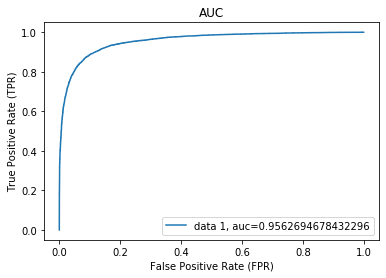

In [196]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  prob_predictions)
auc = metrics.roc_auc_score(y_test, prob_predictions)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('AUC')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

The model has a very high score AUC score (0.956), so it is good classifier.

#### Examples of False Positives

In [197]:
test_df = data.loc[test_start:test_start+len(false_positives)-1,:]

In [198]:
false_positives = (y_pred==1) & (y_test==0)
false_positive_examples = test_df.loc[false_positives]

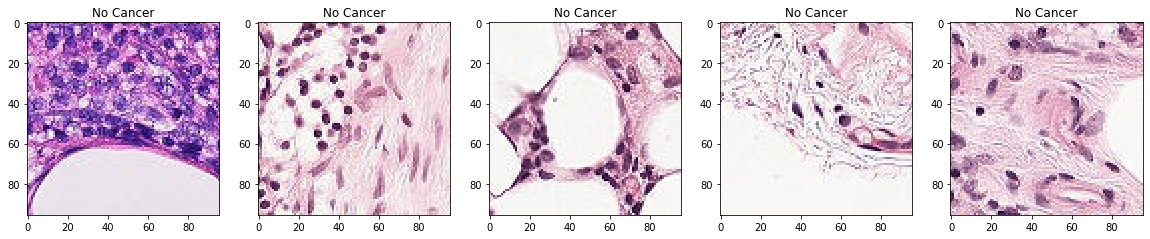

In [199]:
showExampleImages(false_positive_examples, 5, cancer=False)

#### Examples of False Negatives

In [200]:
false_negatives = (y_pred==0) & (y_test==1)
false_negative_examples = test_df.loc[false_negatives]

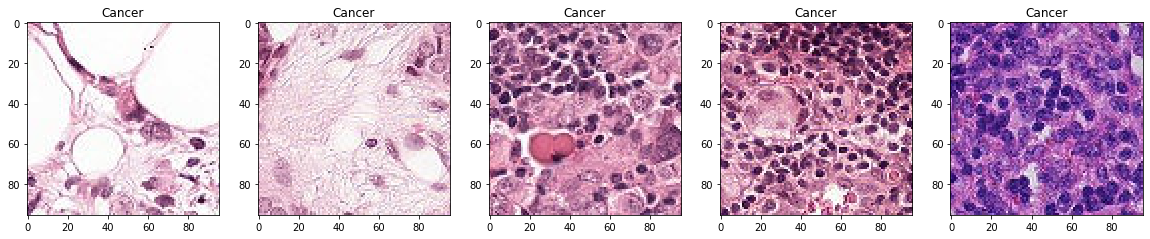

In [201]:
showExampleImages(false_negative_examples, 5, cancer=True)